# Question 1:
What is the problem that the paper aims to solve, and why is this problem important or interesting? 
# Answer

The paper propose a new method for generating high quality images by using probabilistic diffusion models that are trained with  weighted variational bound.

This is an interesting problem where the best results were obtained by training on a weighted variational bound designed according to a novel connection between diffusion probabilistic
models and denoising score matching with Langevin dynamics.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import numpy as np


from tqdm import tqdm


# Question 2:
Implement DDPM and test it on 2-dimensional Swiss roll data. You should output Fig.3 of the blog intro 2

In [ ]:
TIME_STEPS = 100
betas = torch.linspace(1e-5, 1e-2, TIME_STEPS).to(device)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)


In [ ]:
def get_weight_at_t(input, t, x):
    variable_shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(variable_shape) - 1)
    result =  out.reshape(*reshape).to(device)
    return result

def get_diffused_input_at_t(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0).to(device)
    w_1 = get_weight_at_t(alphas_bar_sqrt, t, x_0)
    w_2 = get_weight_at_t(one_minus_alphas_bar_sqrt, t, x_0)
    result = w_1* x_0 + w_2* noise
    return result


def calculate_loss(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].to(device).long()
    e = torch.randn_like(x_0).to(device)
    # model input
    x = x_0 * get_weight_at_t(alphas_bar_sqrt, t, x_0) + e * get_weight_at_t(one_minus_alphas_bar_sqrt, t, x_0)
    output = model(x, t)
    result =  (e - output).square().mean()
    return result


def sample_step(model, x, t, alphas, betas, one_minus_alphas_bar_sqrt):
    t = torch.tensor([t]).to(device)
    # Factor to the model output
    eps_factor = ((1 - get_weight_at_t(alphas, t, x)) / get_weight_at_t(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    x = x.to(device)
    eps_theta = model(x, t)
    # Final values
    mean = (1 / get_weight_at_t(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = get_weight_at_t(betas, t, x).sqrt()
    return mean + sigma_t * z

def sample_loop(model, shape,n_steps,alphas,betas,one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = sample_step(model, cur_x, i,alphas,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def train(dataset, n_size=2, n_hidden=128, epochs=200, n_timesteps=100, verbose=False):
    
    model = DiffusionModel(n_size=n_size, n_steps=n_timesteps, n_hidden=n_hidden).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    batch_size = 128
    for t in tqdm(range(epochs)):
        # X is a torch Variable
        permutation = torch.randperm(dataset.size()[0])
        for i in range(0, dataset.size()[0], batch_size):
            # Retrieve current batch
            indices = permutation[i:i+batch_size]
            batch_x = dataset[indices].to(device)
            # Compute the loss.
            loss = calculate_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt, n_timesteps)
            # Before the backward pass, zero all of the network gradients
            optimizer.zero_grad()
            # Backward pass: compute gradient of the loss with respect to parameters
            loss.backward()
            # Perform gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            # Calling the step function to update the parameters
            optimizer.step()
        if t%10 == 0 and verbose:
            print(loss)
    return model

def visualize_results(model, dataset):
    fig, axs = plt.subplots(2, 3, figsize=(15, 7))

    steps = [0, 50, 99]
    names = ["t = 0", "t = T/2", "t = T"]
    for i, (step, name) in enumerate(zip(steps, names)):

        cur_x = get_diffused_input_at_t(dataset, torch.tensor([step]))
        cur_x = cur_x.cpu().detach()
        axs[0, i].scatter(cur_x[:, 0], cur_x[:, 1],color='red', s=3, alpha=0.1)
        axs[0, i].axis('equal')
        axs[0, i].set_axis_off(); 
        axs[0, i].set_title(name)


    x_list = sample_loop(model, dataset.shape, TIME_STEPS, alphas,betas,one_minus_alphas_bar_sqrt)
    for i, (step, name) in enumerate(zip([100, 50, 0], names)):

        cur_x = x_list[step].cpu().detach()
        axs[1, i].scatter(cur_x[:, 0], cur_x[:, 1],color='blue', s=2, alpha=0.2)
        axs[1, i].axis('equal')
        axs[1, i].set_axis_off()
        axs[1, i].set_title(name)


class LinearWithTimeEmbedding(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(LinearWithTimeEmbedding, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
        
class DiffusionModel(nn.Module):
    def __init__(self, n_size = 2, n_hidden=128, n_steps=None):
        super(DiffusionModel, self).__init__()
        self.layer1 = LinearWithTimeEmbedding(n_size, n_hidden, n_steps)
        self.layer2 = LinearWithTimeEmbedding(n_hidden, n_hidden, n_steps)
        self.layer3 = LinearWithTimeEmbedding(n_hidden, n_hidden, n_steps)
        self.layer4 = nn.Linear(n_hidden, n_size)
    
    def forward(self, x, y):
        for layer in [self.layer1, self.layer2, self.layer3]:
            x = layer(x, y)
            x = F.softplus(x)
        return self.layer4(x)

  0%|          | 1/200 [00:00<01:07,  2.96it/s]

tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 11/200 [00:03<00:50,  3.71it/s]

tensor(1.0011, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 21/200 [00:05<00:49,  3.65it/s]

tensor(0.8364, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 31/200 [00:08<00:45,  3.70it/s]

tensor(0.5845, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 41/200 [00:11<00:43,  3.69it/s]

tensor(0.5282, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 51/200 [00:13<00:40,  3.69it/s]

tensor(0.8305, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 61/200 [00:16<00:37,  3.75it/s]

tensor(0.3789, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 71/200 [00:19<00:34,  3.71it/s]

tensor(0.4550, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 81/200 [00:22<00:32,  3.66it/s]

tensor(0.5292, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 91/200 [00:24<00:29,  3.65it/s]

tensor(0.6187, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 101/200 [00:27<00:26,  3.72it/s]

tensor(0.4805, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 111/200 [00:30<00:23,  3.71it/s]

tensor(0.4292, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 121/200 [00:32<00:21,  3.69it/s]

tensor(0.4610, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 131/200 [00:35<00:18,  3.71it/s]

tensor(0.4779, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 141/200 [00:38<00:16,  3.61it/s]

tensor(0.7110, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 151/200 [00:40<00:13,  3.65it/s]

tensor(0.4356, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 161/200 [00:43<00:10,  3.73it/s]

tensor(0.5224, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 171/200 [00:46<00:07,  3.64it/s]

tensor(0.8424, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 181/200 [00:49<00:05,  3.63it/s]

tensor(0.7494, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 191/200 [00:51<00:02,  3.64it/s]

tensor(0.7225, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 200/200 [00:54<00:00,  3.67it/s]


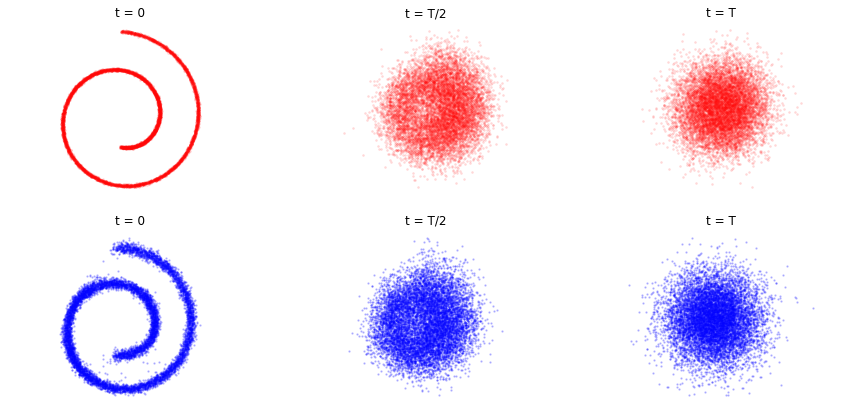

In [ ]:
swiss_roll, _ = make_swiss_roll(10000, noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.

swiss_roll_dataset = torch.Tensor(swiss_roll).to(device).float()
swiss_model = train(swiss_roll_dataset, epochs=200, verbose=True)
visualize_results(swiss_model, swiss_roll_dataset)

# Question 3:
Test DDPM on the mixture of 8 Gaussians

100%|██████████| 200/200 [00:43<00:00,  4.56it/s]


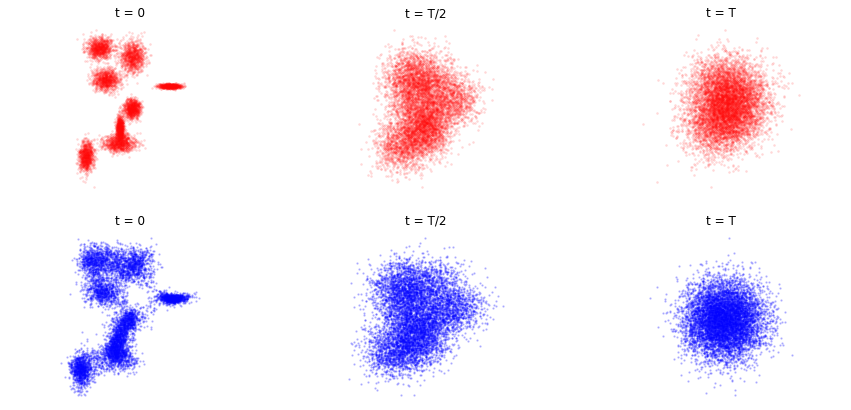

In [ ]:
dataset = []
for i in range(8):
    # randomly create mean and covariant matrix
    gaussian_mean = np.random.rand(2)*2.4 - 1.2
    gaussian_cov = np.diag(np.random.rand(2)*0.03)
    sampled_points = np.random.multivariate_normal(
        gaussian_mean, gaussian_cov, size=1000
    )
    dataset.append(sampled_points)

# generate data 
dataset = np.concatenate(dataset)

# shuffle
np.random.shuffle(dataset)
dataset = torch.Tensor(dataset).to(device).float()

# create new model and train
model_2 = train(dataset, epochs=200)
visualize_results(model_2, dataset)


## 25 Gaussians

100%|██████████| 800/800 [02:32<00:00,  5.25it/s]


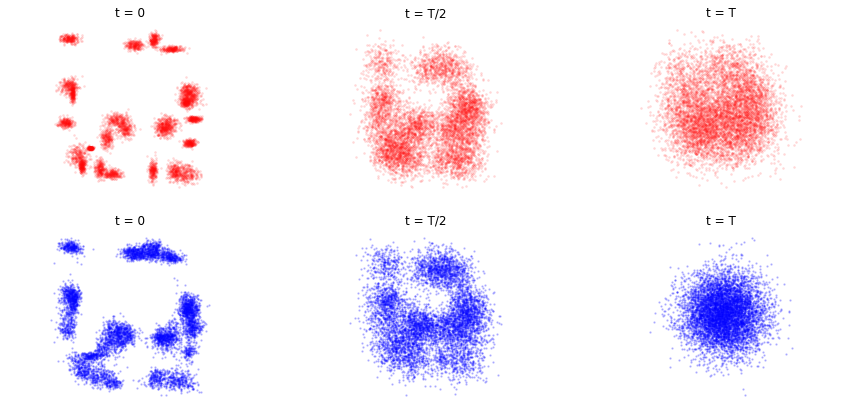

In [ ]:
dataset = []
for _ in range(25):
    # randomly create mean and std matrix
    mean = np.random.rand(2)*4 - 2
    cov = np.diag(np.random.rand(2)*0.03)
    sampled_points = np.random.multivariate_normal(mean, cov, size=280)
    dataset.append(sampled_points)

# generate data 
dataset = np.concatenate(dataset)

# shuffle
np.random.shuffle(dataset)
dataset = torch.Tensor(dataset).to(device).float()

# create new model and train
model_3 = train(dataset, epochs=800)
visualize_results(model_3, dataset)


# Question 4:
Test DDPM on MNIST dataset. Visualize the denoising process (You should output a figure like Fig. 6 in the paper).

In [ ]:
TIME_STEPS = 1000
betas = torch.linspace(1e-4, 1e-2, TIME_STEPS).to(device)
ALPHAS = 1 - betas
alphas_prod = torch.cumprod(ALPHAS, 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)


mnist = torchvision.datasets.MNIST(root="./", download=True)
dataset = mnist.data[:25000].reshape((-1, 28*28)).float()/127.5 -1 
dataset = dataset.to(device)
        
class MnistModel(nn.Module):
    def __init__(self, n_size = 2, n_hidden=128, n_steps=None):
        super(MnistModel, self).__init__()
        self.lin1 = LinearWithTimeEmbedding(n_size, n_hidden, n_steps)
        self.lin2 = LinearWithTimeEmbedding(n_hidden, n_hidden, n_steps)
        self.lin4 = nn.Linear(n_hidden, n_size)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin4(x)

def train_mnist(dataset, n_size=28*28, n_hidden=128, epochs=1000, n_timesteps=100, verbose=False):
    model = MnistModel(n_size=n_size, n_steps=n_timesteps, n_hidden=n_hidden).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    batch_size = 256
    pbar = tqdm(range(epochs))
    for t in pbar:
        # X is a torch Variable
        permutation = torch.randperm(dataset.size()[0])
        for i in range(0, dataset.size()[0], batch_size):
            # Retrieve current batch
            indices = permutation[i:i+batch_size]
            batch_x = dataset[indices].to(device)
            # Compute the loss.
            loss = calculate_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt, n_timesteps)
            # Before the backward pass, zero all of the network gradients
            optimizer.zero_grad()
            # Backward pass: compute gradient of the loss with respect to parameters
            loss.backward()
            # Perform gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            # Calling the step function to update the parameters
            optimizer.step()
        if verbose: 
            pbar.set_description(f"{loss}")
    return model

mnist_model = train_mnist(dataset, n_size=28*28, n_hidden=1024, epochs=1500, n_timesteps=TIME_STEPS, verbose=True)

0.17282763123512268: 100%|██████████| 1500/1500 [09:42<00:00,  2.57it/s]


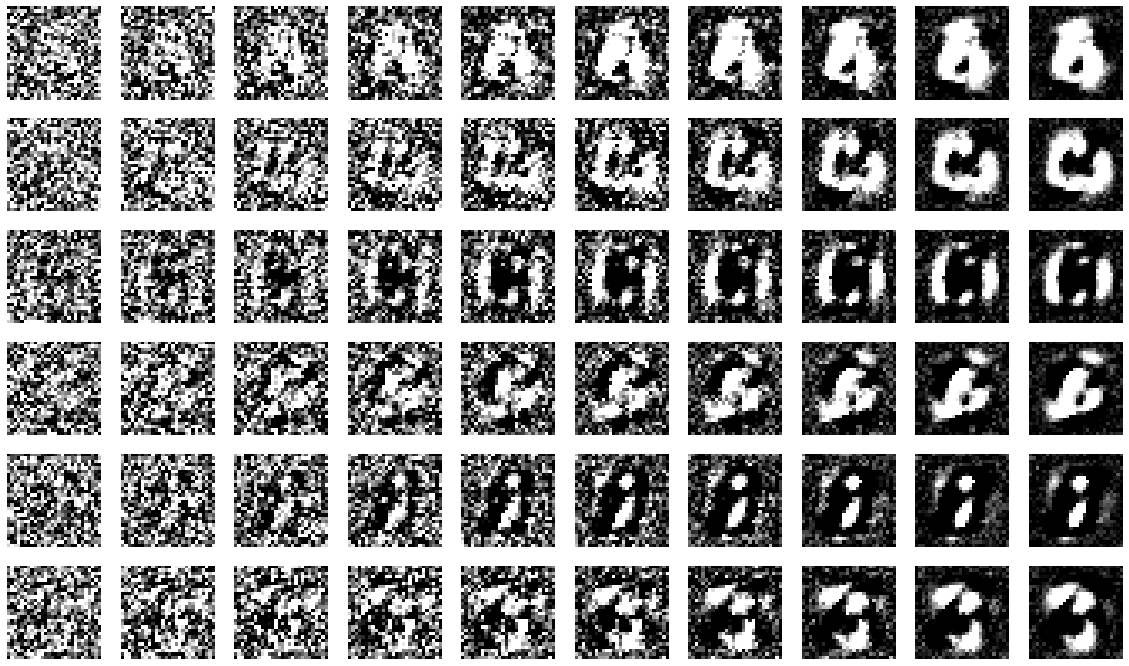

In [ ]:

def array_to_image(arr):
    arr = (arr + 1)*127.5
    arr[arr < 0] = 0
    arr[arr > 255] = 255
    arr = arr.astype(np.uint8).reshape((-1, 28, 28))
    return arr

x_seq = sample_loop(mnist_model, [6, 28*28], TIME_STEPS, ALPHAS, betas, one_minus_alphas_bar_sqrt)
fig, axs = plt.subplots(6, 10, figsize=(20, 12))

for i in range(10):
    index = i*100 + 99
    output = x_seq[index].cpu().detach().numpy()
    output = array_to_image(output)
    for j in range(6):
        axs[j, i].imshow(output[j], cmap=plt.cm.gray)
        axs[j, i].set_axis_off()

# Question 5
Perform an interpolation experiment with your trained model from Problem 4 (You should output a figure like Fig. 8 in the paper).

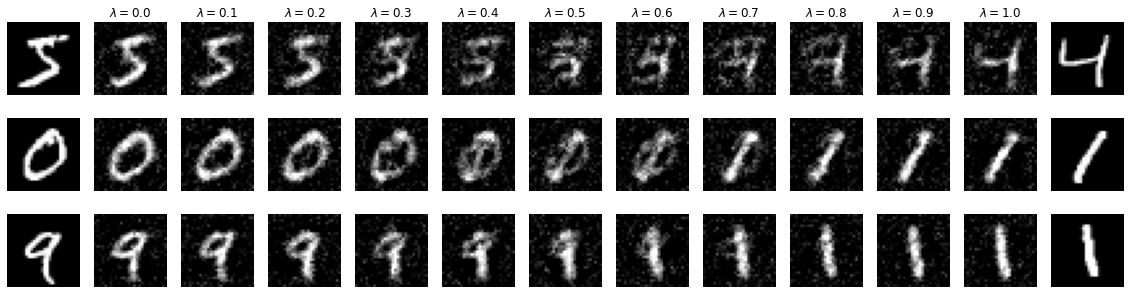

In [ ]:
# select the images to begin
sources = [[0, 2], [1, 3], [4, 6]]
fig, axs = plt.subplots(3, 13, figsize=(20, 5))
for i, (idx_1, idx_2) in enumerate(sources):

    # get the source images
    image_start = dataset[idx_1]
    image_end = dataset[idx_2]

    # plot source images
    axs[i, 0].imshow(array_to_image(image_start.cpu().numpy())[0], cmap=plt.cm.gray); axs[i, 0].set_axis_off()
    axs[i, 12].imshow(array_to_image(image_end.cpu().numpy())[0], cmap=plt.cm.gray); axs[i, 12].set_axis_off()

    noise_start = get_diffused_input_at_t(image_start, torch.tensor([300]))
    noise_end = get_diffused_input_at_t(image_end, torch.tensor([300]))

    for j, alpha in enumerate(np.linspace(0, 1.0, 11)):
        # mixed with different coefficients
        mixed_image = (1- alpha)*image_start.detach() + alpha*image_end.detach()

        # reverse 
        for t in reversed(range(300)):
            mixed_image = sample_step(mnist_model, mixed_image, t, ALPHAS, betas, one_minus_alphas_bar_sqrt)
        
        # plot
        if i == 0:
            axs[i, j + 1].set_title(f"$\lambda = {round(alpha,1)}$")
        axs[i, j + 1].imshow(array_to_image(mixed_image.detach().cpu().numpy())[0], cmap=plt.cm.gray)
        axs[i, j + 1].set_axis_off()